# Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train_bookmark = pd.read_csv('Train/train_bookmark.csv', parse_dates=['dates'], infer_datetime_format=True)
train_service = pd.read_csv('Train/train_service.csv', parse_dates=['registerdate','enddate'], infer_datetime_format=True)
coin = pd.read_csv('Code/coin.csv')
content_info = pd.read_csv('Code/content_info.csv')
movie_info = pd.read_csv('Code/movie_info.csv')
predict_bookmark = pd.read_csv('Predict/predict_bookmark.csv', parse_dates=['dates'], infer_datetime_format=True)
predict_service = pd.read_csv('Predict/predict_service.csv', parse_dates=['registerdate','enddate'], infer_datetime_format=True)

In [2]:
column_code_info_Productcode = pd.read_excel('column_code_info.xlsx', sheet_name='Productcode')
column_code_info_Coin_Productcode = pd.read_excel('column_code_info.xlsx', sheet_name='Coin_Productcode')
column_code_info_payment = pd.read_excel('column_code_info.xlsx', sheet_name='payment')
column_code_info_charge = pd.read_excel('column_code_info.xlsx', sheet_name='charge')
column_code_info_device = pd.read_excel('column_code_info.xlsx', sheet_name='device')
column_code_info_genre = pd.read_excel('column_code_info.xlsx', sheet_name='genre')
column_code_info_section = pd.read_excel('column_code_info.xlsx', sheet_name='section')
column_code_info_channel = pd.read_excel('column_code_info.xlsx', sheet_name='channel')

# 전처리, 결측치 처리

In [3]:
exchange_rate = 1138.5

train_service['promo_100'] = train_service['promo_100'].apply(lambda x: 0 if pd.isna(x) else 1 )
train_service['coinReceived'] = train_service['coinReceived'].apply(lambda x: 0 if pd.isna(x) else 1 )
train_service['isauth'] = train_service['isauth'].apply(lambda x: 0 if pd.isna(x) else 1 )
train_service['Repurchase'] = train_service['Repurchase'].apply(lambda x: 1 if x=='O' else 0)
train_service['gender'] = train_service['gender'].fillna('N')
train_service['pgamount'] = train_service['pgamount'].apply(lambda x: x * exchange_rate if x<100 else x)

predict_service['promo_100'] = predict_service['promo_100'].apply(lambda x: 0 if pd.isna(x) else 1 )
predict_service['coinReceived'] = predict_service['coinReceived'].apply(lambda x: 0 if pd.isna(x) else 1 )
predict_service['isauth'] = predict_service['isauth'].apply(lambda x: 0 if pd.isna(x) else 1 )
# predict_service['Repurchase'] = predict_service['Repurchase'].apply(lambda x: int(1) if x=='X' else int(np.nan))
predict_service['gender'] = predict_service['gender'].fillna('N')
predict_service['pgamount'] = predict_service['pgamount'].apply(lambda x: x * exchange_rate if x<100 else x)

In [4]:
train_service_target = train_service[train_service.enddate >= train_service.registerdate + pd.DateOffset(weeks=3)]
predict_service_target = predict_service[predict_service.enddate >= predict_service.registerdate + pd.DateOffset(weeks=3)]

# EDA

In [26]:
train_service.head()

,uno,registerdate,enddate,productcode,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,tot_view_count,tot_viewtime_sum,tot_viewtime_mean,tot_viewtime_std,view_count,viewtime_sum,viewtime_mean,viewtime_std,RepurchaseRateByProductcode,rateByChargetypeid,devicetype_cnt,auto_pay_yn,coin_productcode,paymenttypeid,currencytypeid,totalamount,coin_pgamount,coinamount,bonusamount,discountamount,productname,coinexpiredate,coin_autopay_yn,run_rate
0,b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3...,2021-03-09 16:31:15,2021-04-09 16:31:15,pk_1487,7900.0,134,1,0,0,0,android,1,F,45,59.0,55940.0,948.135593,828.766168,57.0,53230.0,10947.666667,9358.456573,0.680547,0.704986,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.713182
1,4ec765db76545c1d6dda9f421590bf9d02f584009f8d92...,2021-03-09 14:33:07,2021-04-09 14:33:07,pk_1487,100.0,190,1,1,1,0,pc,1,F,25,27.0,36420.0,1348.888889,1067.622568,18.0,26190.0,14448.333333,4599.236399,0.680547,0.584037,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.742686
2,4f86d917c53cb6bd8949f76dba7260311e8c1748748a02...,2021-03-09 22:23:12,2021-04-09 22:23:12,pk_1487,100.0,132,1,1,0,0,android,0,F,55,132.0,109020.0,825.909091,965.055039,132.0,109020.0,14358.589257,16227.440700,0.680547,0.696782,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.853055
3,6722de45f1c29af6057973492fed22c05e63a7bc90203d...,2021-03-10 21:31:39,2021-04-10 21:31:39,pk_1487,100.0,132,1,1,0,1,android,1,M,40,43.0,20770.0,483.023256,456.156484,32.0,14710.0,1521.666667,701.345933,0.680547,0.696782,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.741085
4,be6700cb07cb7f428d536f6b1bc88e9e37844ab634286d...,2021-03-10 13:35:57,2021-04-10 13:35:57,pk_1487,100.0,180,1,1,0,1,android,1,M,25,10.0,14690.0,1469.000000,1500.877151,4.0,4920.0,2460.000000,1654.629868,0.680547,0.622226,2.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.994526


In [27]:
train_bookmark.head()

,uno,dates,hour,channeltype,programid,title,contentid,contentnumber,section,viewtime,devicetype
0,b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3...,2021-03-20,17,V,S01_P453505934,펜트하우스 2,S01_E454434900.1,9,1,1650,4
1,b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3...,2021-03-13,15,V,M_T60403G,밥이 되어라,M_EP202103053628.1,42,1,1670,4
2,b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3...,2021-03-13,6,V,S01_P453505934,펜트하우스 2,S01_E454336041.1,7,1,1800,4
3,b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3...,2021-03-16,19,V,K02_T2020-0370,오! 삼광빌라!,K02_PS-2021033047-01-000.1,50,1,2080,4
4,b3d6846338d0e98b7e0fcf735c49271ff59df86bfd78f3...,2021-03-18,7,V,M_T60403G,밥이 되어라,M_EP202103123716.1,43,1,1680,4


In [4]:
import sqlite3

conn = sqlite3.connect(':memory:')

train_service.to_sql('train_service', conn, index=False)
train_bookmark.to_sql('train_bookmark', conn, index=False)

In [5]:
query = '''
select train_bookmark.dates, 
       train_bookmark.hour, 
       train_bookmark.channeltype,
       train_bookmark.programid, 
       train_bookmark.title,
       train_bookmark.contentid, 
       train_bookmark.contentnumber,
       train_bookmark.section,
       train_bookmark.viewtime,
       train_bookmark.devicetype,
       train_service.*
from train_bookmark
left join train_service
on train_bookmark.dates >= train_service.registerdate and train_bookmark.dates <= train_service.enddate
and train_service.uno = train_bookmark.uno 
'''
train_merge = pd.read_sql_query(query, conn)
train_merge.head()

KeyboardInterrupt: 

In [9]:
conn.close()

,Repurchase,dates,channeltype,programid,title,contentid,contentnumber,section,viewtime,devicetype
0,X,2021-03-20 00:00:00,V,S01_P453505934,펜트하우스 2,S01_E454434900.1,9,1,1650,4
1,X,2021-03-13 00:00:00,V,M_T60403G,밥이 되어라,M_EP202103053628.1,42,1,1670,4
2,X,2021-03-13 00:00:00,V,S01_P453505934,펜트하우스 2,S01_E454336041.1,7,1,1800,4
3,X,2021-03-16 00:00:00,V,K02_T2020-0370,오! 삼광빌라!,K02_PS-2021033047-01-000.1,50,1,2080,4
4,X,2021-03-18 00:00:00,V,M_T60403G,밥이 되어라,M_EP202103123716.1,43,1,1680,4


# Feature 추가

## View Info

In [6]:
train_bookmark_grb_tot = pd.DataFrame(train_bookmark.groupby(['uno'])['dates'].count())
train_bookmark_grb_tot.rename(columns={'dates':'tot_view_count'}, inplace=True)
train_bookmark_grb_tot.reset_index(drop=False, inplace=True)


train_bookmark_grb_tot = pd.merge(train_bookmark_grb_tot, pd.DataFrame(train_bookmark.groupby(['uno'])['viewtime'].sum()), on=['uno'])
train_bookmark_grb_tot.rename(columns={'viewtime':'tot_viewtime_sum'}, inplace=True)

train_bookmark_grb_tot = pd.merge(train_bookmark_grb_tot, pd.DataFrame(train_bookmark.groupby(['uno'])['viewtime'].mean()), on=['uno'])
train_bookmark_grb_tot.rename(columns={'viewtime':'tot_viewtime_mean'}, inplace=True)

train_bookmark_grb_tot = pd.merge(train_bookmark_grb_tot, pd.DataFrame(train_bookmark.groupby(['uno'])['viewtime'].std()), on=['uno'])
train_bookmark_grb_tot.rename(columns={'viewtime':'tot_viewtime_std'}, inplace=True)

In [7]:
train_service = pd.merge(train_service, train_bookmark_grb_tot, on='uno', how='left')
train_service['tot_view_count'].fillna(0, inplace=True)
train_service['tot_viewtime_sum'].fillna(0, inplace=True)
train_service['tot_viewtime_mean'].fillna(0, inplace=True)
train_service['tot_viewtime_std'].fillna(0, inplace=True)

In [8]:
predict_bookmark_grb_tot = pd.DataFrame(predict_bookmark.groupby(['uno'])['dates'].count())
predict_bookmark_grb_tot.rename(columns={'dates':'tot_view_count'}, inplace=True)
predict_bookmark_grb_tot.reset_index(drop=False, inplace=True)


predict_bookmark_grb_tot = pd.merge(predict_bookmark_grb_tot, pd.DataFrame(predict_bookmark.groupby(['uno'])['viewtime'].sum()), on=['uno'])
predict_bookmark_grb_tot.rename(columns={'viewtime':'tot_viewtime_sum'}, inplace=True)

predict_bookmark_grb_tot = pd.merge(predict_bookmark_grb_tot, pd.DataFrame(predict_bookmark.groupby(['uno'])['viewtime'].mean()), on=['uno'])
predict_bookmark_grb_tot.rename(columns={'viewtime':'tot_viewtime_mean'}, inplace=True)

predict_bookmark_grb_tot = pd.merge(predict_bookmark_grb_tot, pd.DataFrame(predict_bookmark.groupby(['uno'])['viewtime'].std()), on=['uno'])
predict_bookmark_grb_tot.rename(columns={'viewtime':'tot_viewtime_std'}, inplace=True)

In [9]:
predict_service = pd.merge(predict_service, predict_bookmark_grb_tot, on='uno', how='left')
predict_service['tot_view_count'].fillna(0, inplace=True)
predict_service['tot_viewtime_sum'].fillna(0, inplace=True)
predict_service['tot_viewtime_mean'].fillna(0, inplace=True)
predict_service['tot_viewtime_std'].fillna(0, inplace=True)

In [10]:
train_bookmark_grb = pd.DataFrame(train_bookmark.groupby(['uno', 'dates'])['dates'].count())
train_bookmark_grb.rename(columns={'dates':'view_count'}, inplace=True)
train_bookmark_grb.reset_index(drop=False, inplace=True)


train_bookmark_grb = pd.merge(train_bookmark_grb, pd.DataFrame(train_bookmark.groupby(['uno', 'dates'])['viewtime'].sum()), on=['uno', 'dates'])
train_bookmark_grb.rename(columns={'viewtime':'viewtime_sum'}, inplace=True)

train_bookmark_grb = pd.merge(train_bookmark_grb, pd.DataFrame(train_bookmark.groupby(['uno', 'dates'])['viewtime'].mean()), on=['uno', 'dates'])
train_bookmark_grb.rename(columns={'viewtime':'viewtime_mean'}, inplace=True)

train_bookmark_grb = pd.merge(train_bookmark_grb, pd.DataFrame(train_bookmark.groupby(['uno', 'dates'])['viewtime'].std()), on=['uno', 'dates'])
train_bookmark_grb.rename(columns={'viewtime':'viewtime_std'}, inplace=True)

import sqlite3

conn = sqlite3.connect(':memory:')

train_service.to_sql('train_service', conn, index=False)
train_bookmark_grb.to_sql('train_bookmark_grb', conn, index=False)

query = '''
select train_service.uno,
       registerdate, 
       enddate, 
       sum(view_count) view_count, 
       sum(viewtime_sum) viewtime_sum, 
       sum(viewtime_mean) viewtime_mean, 
       sum(viewtime_std) viewtime_std
from train_service
left join train_bookmark_grb
on train_bookmark_grb.dates >= registerdate and train_bookmark_grb.dates <= enddate
and train_service.uno = train_bookmark_grb.uno 
group by train_service.uno, registerdate, enddate
'''
sqlDf = pd.read_sql_query(query, conn)
sqlDf['registerdate'] = pd.to_datetime(sqlDf['registerdate'])
sqlDf['enddate'] = pd.to_datetime(sqlDf['enddate'])
train_service = pd.merge(train_service, sqlDf, on=['uno', 'registerdate', 'enddate'])

In [11]:
predict_bookmark_grp = pd.DataFrame(predict_bookmark.groupby(['uno', 'dates'])['dates'].count())
predict_bookmark_grp.rename(columns={'dates':'view_count'}, inplace=True)
predict_bookmark_grp.reset_index(drop=False, inplace=True)


predict_bookmark_grp = pd.merge(predict_bookmark_grp, pd.DataFrame(predict_bookmark.groupby(['uno', 'dates'])['viewtime'].sum()), on=['uno', 'dates'])
predict_bookmark_grp.rename(columns={'viewtime':'viewtime_sum'}, inplace=True)

predict_bookmark_grp = pd.merge(predict_bookmark_grp, pd.DataFrame(predict_bookmark.groupby(['uno', 'dates'])['viewtime'].mean()), on=['uno', 'dates'])
predict_bookmark_grp.rename(columns={'viewtime':'viewtime_mean'}, inplace=True)

predict_bookmark_grp = pd.merge(predict_bookmark_grp, pd.DataFrame(predict_bookmark.groupby(['uno', 'dates'])['viewtime'].std()), on=['uno', 'dates'])
predict_bookmark_grp.rename(columns={'viewtime':'viewtime_std'}, inplace=True)

import sqlite3

conn = sqlite3.connect(':memory:')

predict_service.to_sql('predict_service', conn, index=False)
predict_bookmark_grp.to_sql('predict_bookmark_grp', conn, index=False)

query = '''
select predict_service.uno,
       registerdate, 
       enddate, 
       sum(view_count) view_count, 
       sum(viewtime_sum) viewtime_sum, 
       sum(viewtime_mean) viewtime_mean, 
       sum(viewtime_std) viewtime_std
from predict_service
left join predict_bookmark_grp
on predict_bookmark_grp.dates >= registerdate and predict_bookmark_grp.dates <= enddate
and predict_service.uno = predict_bookmark_grp.uno 
group by predict_service.uno, registerdate, enddate
'''
sqlDf = pd.read_sql_query(query, conn)
sqlDf['registerdate'] = pd.to_datetime(sqlDf['registerdate'])
sqlDf['enddate'] = pd.to_datetime(sqlDf['enddate'])
predict_service = pd.merge(predict_service, sqlDf, on=['uno', 'registerdate', 'enddate'])

## Productcode별 해지율

In [12]:
rateByproductcode = pd.DataFrame(train_service.groupby(['productcode', 'Repurchase'])['Repurchase'].count()) / pd.DataFrame(train_service.groupby(['productcode'])['Repurchase'].count())
rateByproductcode.columns = ['RepurchaseRateByProductcode']
rateByproductcode.reset_index(inplace=True)

train_service = pd.merge(train_service, 
                 rateByproductcode[rateByproductcode['Repurchase'] == 1][['productcode', 'RepurchaseRateByProductcode']], 
                 on='productcode', how='left')

predict_service = pd.merge(predict_service, 
                 rateByproductcode[rateByproductcode['Repurchase'] == 1][['productcode', 'RepurchaseRateByProductcode']], 
                 on='productcode', how='left')

## chargetypeid별 해지율

In [13]:
rateByChargetypeid = pd.DataFrame(train_service.groupby(['chargetypeid', 'Repurchase'])['Repurchase'].count()) / pd.DataFrame(train_service.groupby(['chargetypeid'])['Repurchase'].count())
rateByChargetypeid.columns = ['rateByChargetypeid']
rateByChargetypeid.reset_index(inplace=True)

train_service = pd.merge(train_service, 
                 rateByChargetypeid[rateByChargetypeid['Repurchase'] == 1][['chargetypeid', 'rateByChargetypeid']], 
                 on='chargetypeid', how='left')

predict_service = pd.merge(predict_service, 
                 rateByChargetypeid[rateByChargetypeid['Repurchase'] == 1][['chargetypeid', 'rateByChargetypeid']], 
                 on='chargetypeid', how='left')

## Device Count

In [14]:
train_service = pd.merge(train_service, 
                 train_bookmark.groupby('uno')['devicetype'].nunique(), 
                 on='uno', how='left')

train_service.rename(columns={'devicetype':'devicetype_cnt'}, inplace=True)

predict_service = pd.merge(predict_service, 
                 predict_bookmark.groupby('uno')['devicetype'].nunique(), 
                 on='uno', how='left')
predict_service.rename(columns={'devicetype':'devicetype_cnt'}, inplace=True)

## 자동결제 여부

In [15]:
column_code_info_Productcode['auto_pay_yn'] = column_code_info_Productcode['description'].str.contains('자동결제')
column_code_info_Productcode['auto_pay_yn'] = column_code_info_Productcode['auto_pay_yn'].apply(lambda x: 1 if x==True else 0)

In [16]:
train_service = pd.merge(train_service, column_code_info_Productcode[['Productcode', 'auto_pay_yn']], left_on='productcode', right_on='Productcode')
train_service.drop('Productcode', axis=1, inplace=True)

predict_service = pd.merge(predict_service, column_code_info_Productcode[['Productcode', 'auto_pay_yn']], left_on='productcode', right_on='Productcode')
predict_service.drop('Productcode', axis=1, inplace=True)

## Coin Info

In [17]:
for column in list(coin.columns):
  if column !='uno' and column != 'registerdate':
    if column in list(train_service.columns):
      coin.rename(columns={column:'coin_'+column}, inplace=True)

In [18]:
column_code_info_Coin_Productcode['coin_autopay_yn'] = column_code_info_Coin_Productcode[['productname']].apply(lambda x:x.str.contains('자동결제'))
column_code_info_Coin_Productcode['coin_autopay_yn'] = column_code_info_Coin_Productcode['coin_autopay_yn'].apply(lambda x:1 if x==True else 0)

In [19]:
coin = pd.merge(coin, column_code_info_Coin_Productcode[['productcode', 'coin_autopay_yn']] , left_on='coin_productcode', right_on='productcode', how='left')
coin.drop('productcode', axis=1, inplace=True)

In [20]:
train_service = pd.merge(train_service, coin, on=['uno', 'registerdate'], how='left')
predict_service = pd.merge(predict_service, coin, on=['uno', 'registerdate'], how='left')

## 시리즈물 시청 정보

In [21]:
import numpy as np
train_bookmark_series = train_bookmark[train_bookmark['contentnumber'].apply(lambda x:str(x).isdigit())]
train_bookmark_series['contentnumber'] = train_bookmark_series['contentnumber'].apply(int)

series_maxnum = train_bookmark_series.groupby('programid')['contentnumber'].max()
series_maxnum = pd.DataFrame(series_maxnum)
series_maxnum.reset_index(inplace=True)
series_maxnum.rename(columns={'contentnumber':'max_contentnumber'}, inplace=True)

train_bookmark_series = pd.merge(train_bookmark_series, series_maxnum, on='programid', how='left')
train_bookmark_series['run_rate'] = train_bookmark_series['contentnumber'] / train_bookmark_series['max_contentnumber']

train_bookmark_series_grp = train_bookmark_series.groupby('uno')['run_rate'].mean()

In [22]:
predict_bookmark_series = predict_bookmark[predict_bookmark['contentnumber'].apply(lambda x:str(x).isdigit())]
predict_bookmark_series['contentnumber'] = predict_bookmark_series['contentnumber'].apply(int)

series_maxnum = predict_bookmark_series.groupby('programid')['contentnumber'].max()
series_maxnum = pd.DataFrame(series_maxnum)
series_maxnum.reset_index(inplace=True)
series_maxnum.rename(columns={'contentnumber':'max_contentnumber'}, inplace=True)

predict_bookmark_series = pd.merge(predict_bookmark_series, series_maxnum, on='programid', how='left')
predict_bookmark_series['run_rate'] = predict_bookmark_series['contentnumber'] / predict_bookmark_series['max_contentnumber']

predict_bookmark_series_grp = predict_bookmark_series.groupby('uno')['run_rate'].mean()

In [23]:
train_service = pd.merge(train_service, train_bookmark_series_grp, on='uno')
predict_service = pd.merge(predict_service, predict_bookmark_series_grp, on='uno')

## 고객별 가입이력

In [24]:
pd.DataFrame(train_service.groupby('uno')['registerdate'].count()).sort_values(by='registerdate', ascending=False)

,registerdate
uno,
a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c362622171c550dcfe7099733a95d986e379eedfcb8edb5adc79c3f2439a56104f63410b83a10131c8ea5,7
6513fff57e32407ab087206e57186ee4cbde4888a5f79702f9caee7d23d008d30360c95fe000694668cd0c5fd557fb0e1a6d4473abbb18652a717ebf2d5c471e,5
9f0e82544e63feb3fbd0eeb81c749932f9aa0be13d5082805cae93dadda5277be3bc4bbdc8af145edab5d890b53b4768e15d2358d58dfb76bb509ad430f732a2,5
b31c10e7354a7eb3b6316780993a1eaf6c4da9023af8462e9583cdc25dffea5aac33f0c47832c6095cff6515748df4b0502d4c048db479b72391d5f64b3b77ba,3
a6e6e6128f41e37c3fab8276d6861b58a12e2f99976df1f55bc736bdb52db94c58487e29a9cef71c7045834409303e02f24127af76d1d08091312406fcfa3bd5,3
...,...
558978dc90e55d270f25d51dce48630264e3d3429012afdc6ec0f973f3f456ba65a008946a9517abe4f7a0a6f74960d8a6064469a07cdd2d7847f4426a842e63,1
5589f3e4774f4e6e199cf75b7162dd9d8c514f6ba0be17189c5d671de9452175707faff829efe05cf4ec9f8191563b4c9d33a765326574efe82cb2bcb707c959,1
558a01ab3054de33706b0962145ba1d668487828ad623e22d3c889459cff6b90d3d154133d90eb4dab45d583d9fbc952c5102cf131341540c689bb5ddc4b0ec2,1


In [25]:
train_service[train_service['uno']=='a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c362622171c550dcfe7099733a95d986e379eedfcb8edb5adc79c3f2439a56104f63410b83a10131c8ea5']

,uno,registerdate,enddate,productcode,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,tot_view_count,tot_viewtime_sum,tot_viewtime_mean,tot_viewtime_std,view_count,viewtime_sum,viewtime_mean,viewtime_std,RepurchaseRateByProductcode,rateByChargetypeid,devicetype_cnt,auto_pay_yn,coin_productcode,paymenttypeid,currencytypeid,totalamount,coin_pgamount,coinamount,bonusamount,discountamount,productname,coinexpiredate,coin_autopay_yn,run_rate
1215,a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c36...,2021-03-09 22:29:36,2021-03-12 23:06:30,pk_1487,7900.0,180,1,0,0,0,pc,0,N,40,26.0,132570.0,5098.846154,2947.293439,NaN,NaN,NaN,NaN,0.680547,0.622226,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.654969
1216,a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c36...,2021-03-07 15:17:04,2021-03-08 14:43:20,pk_1487,7900.0,180,1,0,0,0,pc,0,N,40,26.0,132570.0,5098.846154,2947.293439,NaN,NaN,NaN,NaN,0.680547,0.622226,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.654969
1217,a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c36...,2021-03-04 15:35:46,2021-03-05 08:03:44,pk_1487,7900.0,180,1,0,0,0,pc,0,N,40,26.0,132570.0,5098.846154,2947.293439,NaN,NaN,NaN,NaN,0.680547,0.622226,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.654969
1218,a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c36...,2021-03-12 23:06:30,2021-04-12 23:06:30,pk_1488,10900.0,180,2,0,0,0,pc,0,N,40,26.0,132570.0,5098.846154,2947.293439,22.0,130960.0,11871.607143,4733.659908,0.786112,0.622226,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.654969
1219,a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c36...,2021-03-08 14:43:20,2021-03-09 22:29:36,pk_1488,10900.0,180,2,0,0,0,pc,0,N,40,26.0,132570.0,5098.846154,2947.293439,NaN,NaN,NaN,NaN,0.786112,0.622226,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.654969
1220,a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c36...,2021-03-05 09:03:44,2021-03-07 14:17:04,pk_1488,10900.0,180,2,0,0,0,pc,0,N,40,26.0,132570.0,5098.846154,2947.293439,1.0,140.0,140.000000,NaN,0.786112,0.622226,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.654969
1221,a02a14ff1ab86edbfe46ad5a6a7fce054dc83c39aa7c36...,2021-03-02 20:26:09,2021-03-04 14:35:46,pk_1488,10900.0,180,2,0,0,0,pc,0,N,40,26.0,132570.0,5098.846154,2947.293439,1.0,1330.0,1330.000000,NaN,0.786112,0.622226,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,0.654969


# Feature Select

In [ ]:
train_columns = list(train_service.columns)
train_columns.remove('Repurchase')

In [ ]:
for c in train_service[train_columns].select_dtypes(['float64', 'int64']).columns:
  train_service.fillna(0, inplace=True)

for c in predict_service[train_columns].select_dtypes(['float64', 'int64']).columns:
  predict_service.fillna(0, inplace=True)  

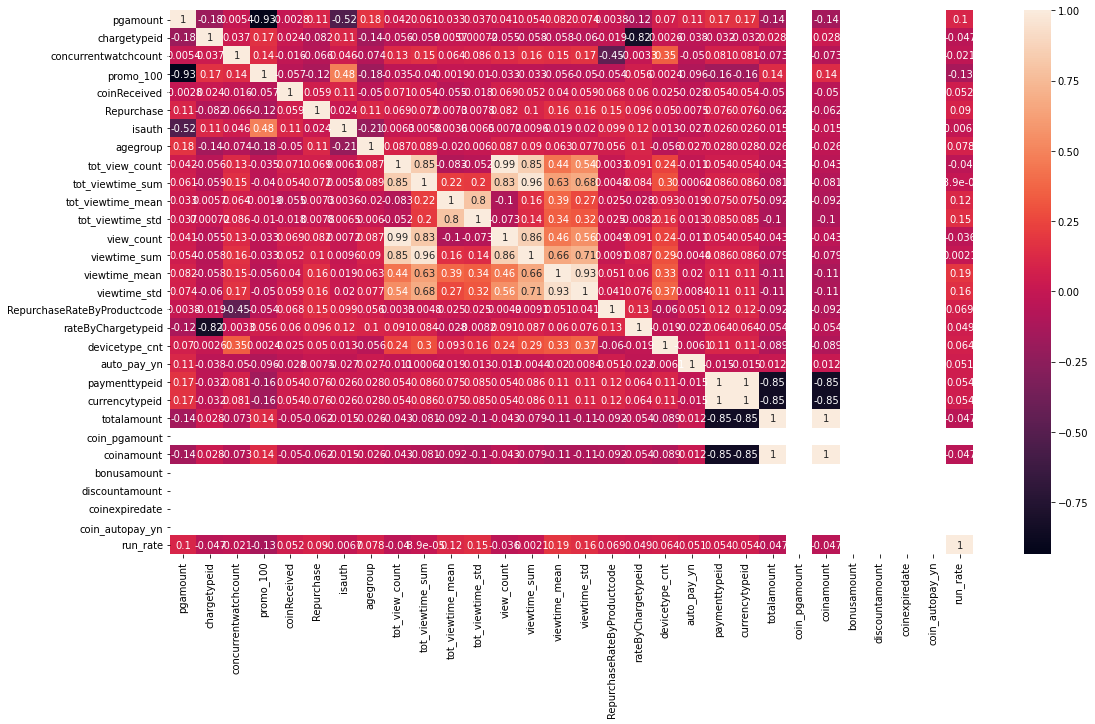

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(18,10))
sns.heatmap(train_service.corr(), annot=True)   

# Model

## KNN

In [ ]:
train_service_target = train_service[train_service.enddate >= (train_service.registerdate + pd.DateOffset(weeks=3))]
predict_service_target = predict_service[predict_service.enddate >= (predict_service.registerdate + pd.DateOffset(weeks=3))]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

params = {
    'n_neighbors' : range(1, 21, 1)   
}
clf = KNeighborsClassifier()
grid_cv = GridSearchCV(clf, param_grid=params, scoring='f1', cv=5, verbose=1)
grid_cv.fit(X_train_norm, y_train)

# clf.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test_norm)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  7.1min finished


0.807398415128012
{'n_neighbors': 19}
              precision    recall  f1-score   support

           0       0.60      0.28      0.38      4471
           1       0.73      0.91      0.81      9471

    accuracy                           0.71     13942
   macro avg       0.66      0.60      0.60     13942
weighted avg       0.69      0.71      0.67     13942



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(train_service_target[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service_target['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service_target['Repurchase'])

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

params = {
    'n_neighbors' : range(1, 21, 1)   
}
clf = KNeighborsClassifier()
grid_cv = GridSearchCV(clf, param_grid=params, scoring='f1', cv=5, verbose=1)
grid_cv.fit(X_train_norm, y_train)

# clf.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test_norm)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.9min finished


0.3859388666150304
{'n_neighbors': 1}
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      9470
           1       0.39      0.38      0.39      4359

    accuracy                           0.62     13829
   macro avg       0.56      0.55      0.55     13829
weighted avg       0.62      0.62      0.62     13829



## Decision Tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

params = {
    'max_depth' : range(1, 21, 2),
    'min_samples_split' : range(1, 11, 1)    
}
clf = DecisionTreeClassifier()
grid_cv = GridSearchCV(clf, param_grid=params, scoring='f1', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

# clf.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.8min finished


0.8181200858779236
{'max_depth': 5, 'min_samples_split': 3}
              precision    recall  f1-score   support

           0       0.66      0.17      0.27      4210
           1       0.71      0.96      0.82      9082

    accuracy                           0.71     13292
   macro avg       0.69      0.56      0.54     13292
weighted avg       0.70      0.71      0.64     13292



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(train_service_target[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service_target['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service_target['Repurchase'])

params = {
    'max_depth' : range(1, 21, 2),
    'min_samples_split' : range(1, 11, 1)    
}
clf = DecisionTreeClassifier()
grid_cv = GridSearchCV(clf, param_grid=params, scoring='f1', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

# clf.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.3min finished


0.37715020991833964
{'max_depth': 19, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      9470
           1       0.44      0.32      0.37      4359

    accuracy                           0.66     13829
   macro avg       0.58      0.57      0.57     13829
weighted avg       0.63      0.66      0.64     13829



In [ ]:
pred_submission = clf.predict(predict_service[train_columns].select_dtypes(['float64', 'int64']))
predict_service['pred'] = pred_submission
predict_service.head()

## RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

rcf = RandomForestClassifier()
rcf.fit(X_train, y_train)
pred = rcf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.59      0.28      0.38      4210
           1       0.73      0.91      0.81      9082

    accuracy                           0.71     13292
   macro avg       0.66      0.60      0.60     13292
weighted avg       0.69      0.71      0.68     13292



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(train_service_target[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service_target['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service_target['Repurchase'])

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

rcf = RandomForestClassifier()
rcf.fit(X_train, y_train)
pred = rcf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.57      0.26      0.36      4101
           1       0.73      0.91      0.81      9081

    accuracy                           0.71     13182
   macro avg       0.65      0.59      0.59     13182
weighted avg       0.68      0.71      0.67     13182



In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

col_list = list(np.abs(train_service.corrwith(train_service['Repurchase'])).sort_values(ascending=False).index)
col_list.remove('Repurchase')

for i in range(1, len(col_list)+1):  
  train_columns = col_list[:i]
  X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                      train_service['Repurchase'], 
                                                      test_size=0.2, 
                                                      stratify=train_service['Repurchase'])

  rcf = RandomForestClassifier()
  rcf.fit(X_train, y_train)
  pred = rcf.predict(X_test)
  print(train_columns, classification_report(y_test, pred))

['viewtime_mean']               precision    recall  f1-score   support

           0       0.34      0.35      0.34      4210
           1       0.69      0.68      0.69      9082

    accuracy                           0.58     13292
   macro avg       0.52      0.52      0.52     13292
weighted avg       0.58      0.58      0.58     13292

['viewtime_mean', 'viewtime_std']               precision    recall  f1-score   support

           0       0.38      0.24      0.29      4210
           1       0.70      0.82      0.75      9082

    accuracy                           0.64     13292
   macro avg       0.54      0.53      0.52     13292
weighted avg       0.60      0.64      0.61     13292

['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode']               precision    recall  f1-score   support

           0       0.40      0.28      0.33      4210
           1       0.71      0.81      0.75      9082

    accuracy                           0.64     13292
   macro av

In [ ]:
pred_submission = rcf.predict(predict_service[train_columns].select_dtypes(['float64', 'int64']))
predict_service['pred'] = pred_submission
predict_service.head()

## Randomforest GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

params = {
    'n_estimators': [300], #list(range(100, 501, 100)),
#     'max_features' : [int(np.sqrt(len(train_columns)))],
    'max_depth' : [6], #range(1, 10, 1),
    'min_samples_leaf': [5], #range(1, 11, 1),
    'min_samples_split': [2] #list(range(1, 11, 1))
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
grid_cv.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

0.2614135182735909
{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      9471
           1       0.72      0.17      0.27      4471

    accuracy                           0.71     13942
   macro avg       0.72      0.57      0.55     13942
weighted avg       0.72      0.71      0.64     13942



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(train_service_target[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service_target['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service_target['Repurchase'])

params = {
    'n_estimators': [300], #list(range(100, 501, 100)),
#     'max_features' : [int(np.sqrt(len(train_columns)))],
    'max_depth' : [6], #range(1, 10, 1),
    'min_samples_leaf': [5], #range(1, 11, 1),
    'min_samples_split': [2] #list(range(1, 11, 1))
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
grid_cv.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

0.24538040201509212
{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.71      0.97      0.82      9470
           1       0.70      0.14      0.23      4359

    accuracy                           0.71     13829
   macro avg       0.70      0.56      0.53     13829
weighted avg       0.71      0.71      0.64     13829



In [ ]:
pred_submission = grid_cv.predict(predict_service[train_columns].select_dtypes(['float64', 'int64']))
predict_service['pred'] = pred_submission
predict_service.head()

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

svm = SVC(kernel='rbf', gamma=0.10, C=10.0)
svm.fit(X_train, y_train)
pred = svm.predict(X_test)
print(classification_report(y_test, pred))

KeyboardInterrupt: ignored

## XGBClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

# xgb_wrapper = XGBRFClassifier(n_estimators=400, learning_rate=0.1, max_depth=15)
# xgb_wrapper.fit(X_train, y_train)
# pred = xgb_wrapper.predict(X_test)

xgb_wrapper = XGBClassifier(objective = 'binary:logistic')
params = {
     'n_estimators': [300],
    'learning_rate' : [0.1],
    'max_depth': [20],
    'min_samples_split': [1]
}

grid_cv = GridSearchCV(xgb_wrapper, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
grid_cv.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

0.8018302575196061
{'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 1, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.56      0.29      0.38      4210
           1       0.73      0.89      0.80      9082

    accuracy                           0.70     13292
   macro avg       0.64      0.59      0.59     13292
weighted avg       0.68      0.70      0.67     13292



In [ ]:

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from itertools import combinations

col_list = list(np.abs(train_service.corrwith(train_service['Repurchase'])).sort_values(ascending=False).index)
col_list.remove('Repurchase')

scoreList = []
for i in range(1, len(col_list)+1):  
  # train_columns_comb = list(combinations(col_list, i))
  # for c in train_columns_comb:
    train_columns = col_list[:i]
    X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                        train_service['Repurchase'], 
                                                        test_size=0.2, 
                                                        stratify=train_service['Repurchase'])

    xgb_wrapper = XGBClassifier(objective = 'binary:logistic')
    params = {
        'n_estimators': [300],
        'learning_rate' : [0.1],
        'max_depth': [20],
        'min_samples_split': [1]
    }

    grid_cv = GridSearchCV(xgb_wrapper, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
    grid_cv.fit(X_train, y_train)
    pred = grid_cv.best_estimator_.predict(X_test)
    # print(grid_cv.best_score_)
    # print(grid_cv.best_params_)
    # print(train_columns, ':', classification_report(y_test, pred))
    print(train_columns, classification_report(y_test, pred).split('\n')[2].split(' ')[30], classification_report(y_test, pred).split('\n')[3].split(' ')[30])
    scoreList.append([train_columns, classification_report(y_test, pred).split('\n')[2].split(' ')[30], classification_report(y_test, pred).split('\n')[3].split(' ')[30]])

pd.DataFrame(scoreList, columns=['columns', 'f1-0', 'f1-1'])

['viewtime_mean'] 0.20 0.79
['viewtime_mean', 'viewtime_std'] 0.23 0.79
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode'] 0.27 0.78
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode', 'promo_100'] 0.32 0.78
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode', 'promo_100', 'agegroup'] 0.35 0.79
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode', 'promo_100', 'agegroup', 'pgamount'] 0.34 0.79
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode', 'promo_100', 'agegroup', 'pgamount', 'viewtime_sum'] 0.34 0.79
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode', 'promo_100', 'agegroup', 'pgamount', 'viewtime_sum', 'rateByChargetypeid'] 0.34 0.78
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode', 'promo_100', 'agegroup', 'pgamount', 'viewtime_sum', 'rateByChargetypeid', 'run_rate'] 0.34 0.79
['viewtime_mean', 'viewtime_std', 'RepurchaseRateByProductcode', 'promo_100', 'agegroup', 'pgamount', 'viewtime_s

,columns,f1-0,f1-1
0,[viewtime_mean],0.20,0.79
1,"[viewtime_mean, viewtime_std]",0.23,0.79
2,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.27,0.78
3,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.32,0.78
4,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.35,0.79
5,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.34,0.79
6,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.34,0.79
7,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.34,0.78
8,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.34,0.79
9,"[viewtime_mean, viewtime_std, RepurchaseRateBy...",0.35,0.79


In [ ]:
resultDf = pd.DataFrame(scoreList, columns=['columns', 'f1-0', 'f1-1'])
resultDf.to_csv('result.csv')

In [ ]:
train_columns = list(set(train_columns))

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(train_service_target[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service_target['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service_target['Repurchase'])

xgb_wrapper = XGBClassifier(objective = 'binary:logistic')
params = {
     'n_estimators': [300],
    'learning_rate' : [0.1],
    'max_depth': [20],
    'min_samples_split': [1]
}

grid_cv = GridSearchCV(xgb_wrapper, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
grid_cv.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

0.8005553764411257
{'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 1, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.53      0.29      0.37      4359
           1       0.73      0.88      0.80      9470

    accuracy                           0.69     13829
   macro avg       0.63      0.58      0.58     13829
weighted avg       0.67      0.69      0.66     13829



In [ ]:
pred_submission = grid_cv.best_estimator_.predict(predict_service_target[train_columns].select_dtypes(['float64', 'int64']))
predict_service_target['pred'] = pred_submission
predict_service_target.head()

,uno,registerdate,enddate,productcode,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,tot_view_count,tot_viewtime_sum,tot_viewtime_mean,tot_viewtime_std,view_count,viewtime_sum,viewtime_mean,viewtime_std,RepurchaseRateByProductcode,rateByChargetypeid,devicetype_cnt,pred
0,9c1c04380d3ec71c9ea55cb99ad803ab7c0037a3482b9b...,2021-03-14 16:44:57,2021-04-14 16:44:57,pk_1487,100.0,190,1,1,0,0,mobile,1,F,20,87.0,96890.0,1113.678161,948.960404,87.0,96890.0,15847.277778,11693.723742,0.319453,0.415963,2.0,0
1,b725d844efdb214963a6ccae004778d0fe40f8a0b5e901...,2021-03-14 21:33:10,2021-04-14 21:33:10,pk_1488,100.0,134,2,1,0,0,android,1,M,35,48.0,24240.0,505.000000,488.684731,41.0,20970.0,5508.378788,3402.540033,0.213888,0.295014,2.0,0
2,7de6c80c6cb5c5098bbfef8d9da75dfdd338b681d96691...,2021-03-14 10:55:38,2021-04-14 10:55:38,pk_2025,100.0,151,1,1,0,0,android,1,M,40,13.0,9460.0,727.692308,1304.077924,0.0,0.0,0.000000,0.000000,0.293849,0.304445,2.0,1
3,a5a209071166d24243bf47955ca91bb590a9d3bee46d71...,2021-03-14 00:19:21,2021-04-14 00:19:21,pk_1488,10900.0,190,2,0,0,0,android,0,M,40,151.0,178570.0,1182.582781,1022.527238,147.0,173160.0,20966.731962,16397.213048,0.213888,0.415963,3.0,0
4,7a6960912bebe03c6e4c770eb1aa91329c3497f18f90ca...,2021-03-14 20:08:31,2021-04-14 20:08:31,pk_1489,100.0,134,4,1,0,0,pc,1,F,20,36.0,27890.0,774.722222,645.660176,33.0,25890.0,7201.818182,4224.081604,0.439507,0.295014,2.0,1


## XGBRFClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRFClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

# xgb_wrapper = XGBRFClassifier(n_estimators=400, learning_rate=0.1, max_depth=15)
# xgb_wrapper.fit(X_train, y_train)
# pred = xgb_wrapper.predict(X_test)

xgb_wrapper = XGBRFClassifier(objective = 'binary:logistic')
params = {
     'n_estimators': [300],
    'learning_rate' : [0.1],
    'max_depth': [20],
    'min_samples_split': [1, 2, 3, 4, 5]
}

grid_cv = GridSearchCV(xgb_wrapper, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
grid_cv.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

KeyboardInterrupt: ignored

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRFClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(train_service_target[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service_target['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service_target['Repurchase'])

# xgb_wrapper = XGBRFClassifier(n_estimators=400, learning_rate=0.1, max_depth=15)
# xgb_wrapper.fit(X_train, y_train)
# pred = xgb_wrapper.predict(X_test)

xgb_wrapper = XGBRFClassifier(objective = 'binary:logistic')
params = {
     'n_estimators': [300],
    'learning_rate' : [0.1],
    'max_depth': [20],
    'min_samples_split': [1]
}

grid_cv = GridSearchCV(xgb_wrapper, param_grid=params, cv=5, n_jobs=-1, scoring='f1')
grid_cv.fit(X_train, y_train)
pred = grid_cv.best_estimator_.predict(X_test)
print(grid_cv.best_score_)
print(grid_cv.best_params_)
print(classification_report(y_test, pred))

0.3603004609184606
{'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 1, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      9470
           1       0.59      0.28      0.38      4359

    accuracy                           0.71     13829
   macro avg       0.66      0.59      0.59     13829
weighted avg       0.69      0.71      0.67     13829



In [ ]:
predict_service.shape

(290, 27)

In [ ]:
pred_submission = grid_cv.best_estimator_.predict(predict_service[train_columns].select_dtypes(['float64', 'int64']))
predict_service['pred'] = pred_submission
predict_service.head()

,uno,registerdate,enddate,productcode,pgamount,chargetypeid,concurrentwatchcount,promo_100,coinReceived,Repurchase,devicetypeid,isauth,gender,agegroup,tot_view_count,tot_viewtime_sum,tot_viewtime_mean,tot_viewtime_std,view_count,viewtime_sum,viewtime_mean,viewtime_std,RepurchaseRateByProductcode,rateByChargetypeid,devicetype_cnt,pred
0,9c1c04380d3ec71c9ea55cb99ad803ab7c0037a3482b9b...,2021-03-14 16:44:57,2021-04-14 16:44:57,pk_1487,100.0,190,1,1,0,NaN,mobile,1,F,20,87.0,96890.0,1113.678161,948.960404,87.0,96890.0,1113.678161,948.960404,0.317885,0.429221,2,0
1,0c8318c090133aa5e354b88ebfe3d392e226d919a3e5e7...,2021-03-13 12:41:42,2021-04-13 12:41:42,pk_1487,100.0,190,1,1,0,NaN,pc,1,M,40,89.0,113730.0,842.444444,809.227074,135.0,113730.0,842.444444,809.227074,0.317885,0.429221,4,0
2,f4fbd206eb9c6bee476a2d25b16a18eaaa05690b48a6de...,2021-03-13 22:13:29,2021-04-13 22:13:29,pk_1487,7900.0,190,1,0,0,NaN,android,1,F,20,74.0,87090.0,1131.038961,893.061830,77.0,87090.0,1131.038961,893.061830,0.317885,0.429221,2,0
3,b50bc7481c7a916afca744f4adf5d1fb48b6096c9592a4...,2021-03-14 04:30:56,2021-04-14 04:30:56,pk_1487,100.0,190,1,1,0,NaN,mobile,1,F,30,14.0,19890.0,1420.714286,1092.312045,14.0,19890.0,1420.714286,1092.312045,0.317885,0.429221,3,0
4,abbdfb282e09f9b9a1fa43ced47806f15cb7e65cde4e19...,2021-03-14 07:35:31,2021-04-14 07:35:31,pk_1487,100.0,190,1,1,0,NaN,mobile,1,M,20,27.0,26320.0,974.814815,850.363589,27.0,26320.0,974.814815,850.363589,0.317885,0.429221,2,0


## Voting

In [ ]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(train_service[train_columns].select_dtypes(['float64', 'int64']), 
                                                    train_service['Repurchase'], 
                                                    test_size=0.2, 
                                                    stratify=train_service['Repurchase'])

lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)
rf_clf = RandomForestClassifier()
xgv_clf = XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=20, min_samples_split=1)
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf), ('RF', rf_clf), ('XGB', xgv_clf)], voting='soft')

vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.63      0.21      0.31      4210
           1       0.72      0.94      0.82      9082

    accuracy                           0.71     13292
   macro avg       0.67      0.57      0.56     13292
weighted avg       0.69      0.71      0.66     13292



# Submission

In [ ]:
# 결과 제출 답안지 불러오기
predict_service['Churn'] = predict_service['pred'].apply(lambda x: 0 if x==1 else 1)
# predict_service['Churn'] = predict_service['pred']

ds_sheet = "/content/drive/MyDrive/SK_AI/CDS_submission.csv"
df_sheet = pd.read_csv(ds_sheet)
df_sheet.drop('CHURN', axis=1, inplace=True)
df_sheet.info()

# 답안지에 답안 표기
df_result = predict_service.loc[:,('uno','registerdate','productcode')]
df_result['KEY']   = df_result['uno'] + '|' + df_result['registerdate'].dt.strftime('%y-%m-%d %I:%M:%S') + '|' + df_result['productcode']   # 판다스 strftime()
df_result['CHURN'] = predict_service['Churn']
df_result = df_result.loc[:,('KEY','CHURN')]
df_answer_sheet = pd.merge(df_sheet, df_result, on='KEY', how='left')
df_answer_sheet['CHURN'] = df_answer_sheet['CHURN'].apply(int)

# 답안지 제출 파일 생성하기
ds_answer_sheet = "CDS_submission_XGBRFClassifier.csv"
df_answer_sheet.to_csv(ds_answer_sheet, index=False, encoding='utf8')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18753 entries, 0 to 18752
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   KEY     18753 non-null  object
dtypes: object(1)
memory usage: 146.6+ KB
